In [1]:
import pandas as pd
import numpy as np
import os
participant_status = pd.read_csv('/Users/saada/Desktop/Digibiomics/Tuberculosis/metadata/CODA_TB_Clinical_Meta_Info.csv')
participant_status = participant_status[['tb_status', 'participant']]


determination_folders = ["X_test_Fold_0.csv", "X_test_Fold_1.csv", "X_test_Fold_2.csv", "X_train_Fold_0.csv", "X_train_Fold_1.csv", "X_train_Fold_2.csv"]

def load_audio_data(folders):
    """
    Function to load multiple CSV files and concatenate them into a single DataFrame.
    """
    dataframes = []
    for folder in folders:
        indicators_df = pd.read_csv(os.path.join('/Users/saada/Desktop/Digibiomics/Tuberculosis/metadata', folder))
        dataframes.append(indicators_df)
    return pd.concat(dataframes, ignore_index=True)


id_check = load_audio_data(determination_folders)




In [2]:
positive_audio_files = id_check[id_check['tb_status'] == 1]
negative_audio_files = id_check[id_check['tb_status'] == 0]

negative_audio_files

,participant,filename,tb_status
0,CODA_TB_0958,1635771153340-recording-1.wav,0
1,CODA_TB_0263,1647419981917-recording-1.wav,0
2,CODA_TB_0633,1645508087846-recording-1.wav,0
3,CODA_TB_0614,1637563732787-recording-1.wav,0
4,CODA_TB_0933,1649055445570-recording-1.wav,0
...,...,...,...
23446,CODA_TB_0939,1639965759322-recording-1.wav,0
23447,CODA_TB_0240,1656574024918-recording-1.wav,0
23448,CODA_TB_0953,1645079179547-recording-1.wav,0
23449,CODA_TB_1081,1628071760949-recording-1.wav,0


In [3]:
import shutil

def sort_data():
    """
    Function sorts audio files into positive and negative directories based on their metadata.
    """

    longitudinal_path = '/Users/saada/Desktop/Digibiomics/Tuberculosis/all_data'

    files = os.listdir(longitudinal_path)
    # Loop through each file in the directory
    # and load the audio files using librosa
    # Collecting the file name, duration, sampling rate, and audio data
    for file in files:
        source_path = os.path.join(longitudinal_path, file)
        positive_path = os.path.join('/Users/saada/Desktop/Digibiomics/Tuberculosis/positive_data', file)
        negative_path = os.path.join('/Users/saada/Desktop/Digibiomics/Tuberculosis/negative_data', file)
        if file.endswith('.wav'):
            if file in positive_audio_files['filename'].values:
                shutil.copy2(source_path, positive_path)

            if file in negative_audio_files['filename'].values:
                shutil.copy2(source_path, negative_path)

    return "Completed sorting audio files into positive and negative directories."
            





In [4]:
sort_data()

'Completed sorting audio files into positive and negative directories.'

In [5]:
import tensorflow as tf
import tensorflow_io as tfio
import numpy as np
import matplotlib.pyplot as plt 

def load_audio(file_path):

    """Load an audio file and return its waveform and sample rate."""

    audio_binary = tf.io.read_file(file_path)
    audio, sample_rate = tf.audio.decode_wav(audio_binary)
    waveform = tf.squeeze(audio, axis=-1)
    return waveform, sample_rate



In [6]:
positive_waveforms = []
negative_waveforms = []
positive_sample_rates = []
negative_sample_rates = []


for pos_audio in os.listdir('/Users/saada/Desktop/Digibiomics/Tuberculosis/positive_data'):
    if pos_audio.endswith('.wav'):
        waveform, sample_rate = load_audio(os.path.join('/Users/saada/Desktop/Digibiomics/Tuberculosis/positive_data', pos_audio))
        positive_waveforms.append(waveform.numpy())
        positive_sample_rates.append(sample_rate.numpy())


for neg_audio in os.listdir('/Users/saada/Desktop/Digibiomics/Tuberculosis/negative_data'):
    if neg_audio.endswith('.wav'):
        waveform, sample_rate = load_audio(os.path.join('/Users/saada/Desktop/Digibiomics/Tuberculosis/negative_data', neg_audio))
        negative_waveforms.append(waveform.numpy())
        negative_sample_rates.append(sample_rate.numpy())

In [7]:
print(positive_sample_rates[0])
#print(len(positive_waveforms[12]))

44100


In [8]:
import librosa
import os

def get_average_audio_length_seconds(folder_path):
    total_duration = 0
    file_count = 0

    for filename in os.listdir(folder_path):
        if filename.endswith(".wav"):
            filepath = os.path.join(folder_path, filename)
            y, sr = librosa.load(filepath, sr=16000)  # use 16kHz sample rate
            duration = len(y) / sr  # seconds
            total_duration += duration
            file_count += 1

    if file_count == 0:
        return 0
    return (total_duration / file_count)

# Example usage:
positive_folder = "/Users/saada/Desktop/Digibiomics/Tuberculosis/positive_data"
negative_folder = "/Users/saada/Desktop/Digibiomics/Tuberculosis/negative_data"
avg_duration = get_average_audio_length_seconds(negative_folder)
print(f"Average audio length: {avg_duration} seconds")




Average audio length: 0.49899318888279404 seconds


In [9]:
TARGET_LEN = int(avg_duration* 16000)

import numpy as np
import librosa

def fix_length(waveform, target_len):
    """    Function to fix the length of audio waveforms to a target length.
    If the waveform is shorter than the target length, it will be padded with zeros.
    If it is longer, it will be truncated.
    """
    if len(waveform) > target_len:
        # Truncate longer waveforms
        return waveform[:target_len]
    else:
        # Pad shorter waveforms with zeros at the end
        return np.pad(waveform, (0, target_len - len(waveform)), mode='constant')


In [ ]:
def load_and_fix_audio(filepath, sr = 16000, TARGET_LEN=TARGET_LEN  ):
    """Load an audio file and fix its length to the target length."""
    y, _ = librosa.load(filepath, sr=sr)
    y_fixed = fix_length(y, TARGET_LEN)
    return y_fixed

def process_folder(folder_path, sr, target_len):
    """Process all audio files in a folder, loading and fixing their lengths."""
    data = []
    for filename in os.listdir(folder_path):
        if filename.endswith(".wav"):
            filepath = os.path.join(folder_path, filename)
            y_fixed = load_and_fix_audio(filepath, sr, target_len)
            data.append(y_fixed)
    return np.array(data)


In [11]:
def waveform_to_mel_spectrogram(waveform, sr=16000, n_mels=128, target_shape=(128, 128)):
    """Convert a waveform to a mel spectrogram and resize it to a consistent shape."""
    mel = librosa.feature.melspectrogram(y=waveform, sr=sr, n_mels=n_mels)
    mel_db = librosa.power_to_db(mel, ref=np.max)

    # Normalize to [0, 1] (per spectrogram)
    mel_min = mel_db.min()
    mel_max = mel_db.max()
    mel_norm = (mel_db - mel_min) / (mel_max - mel_min + 1e-6)

    # Resize to target shape
    mel_resized = tf.image.resize(mel_norm[..., np.newaxis], target_shape).numpy()
    return mel_resized  # shape: (128, 128, 1)

def convert_all_to_mel_spectrograms(waveforms, sr=16000):
    """Convert a list of waveforms to mel spectrograms."""
    mel_specs = []
    for waveform in waveforms:
        mel = waveform_to_mel_spectrogram(waveform, sr=sr)
        mel_specs.append(mel)
    return np.array(mel_specs)  # shape: (N, 128, 128, 1)


In [12]:
convert_all_to_mel_spectrograms(positive_waveforms, sr=16000)

array([[[[4.00433540e-01],
         [4.01365668e-01],
         [4.21872586e-01],
         ...,
         [5.40904105e-01],
         [5.46793759e-01],
         [5.47061443e-01]],

        [[4.15153116e-01],
         [4.16123152e-01],
         [4.37463611e-01],
         ...,
         [6.31190360e-01],
         [6.17919743e-01],
         [6.17316544e-01]],

        [[2.74815261e-01],
         [2.76807636e-01],
         [3.20640147e-01],
         ...,
         [5.62843800e-01],
         [5.48333287e-01],
         [5.47673702e-01]],

        ...,

        [[0.00000000e+00],
         [0.00000000e+00],
         [0.00000000e+00],
         ...,
         [5.52825406e-02],
         [4.36732545e-02],
         [4.31455597e-02]],

        [[0.00000000e+00],
         [0.00000000e+00],
         [0.00000000e+00],
         ...,
         [1.25407137e-03],
         [5.45248404e-05],
         [0.00000000e+00]],

        [[0.00000000e+00],
         [0.00000000e+00],
         [0.00000000e+00],
         ...,
 

In [14]:
positive_specs = [waveform_to_mel_spectrogram(w) for w in positive_waveforms]
negative_specs = [waveform_to_mel_spectrogram(w) for w in negative_waveforms]

positive_labels = [1] * len(positive_specs)
negative_labels = [0] * len(negative_specs)

X = np.array(positive_specs + negative_specs)
y = np.array(positive_labels + negative_labels)


In [15]:
from sklearn.utils import resample
import numpy as np
from sklearn.model_selection import train_test_split

# Separate positive and negative samples
X_pos = X[y == 1]
X_neg = X[y == 0]
y_pos = y[y == 1]
y_neg = y[y == 0]

# Upsample positive class to match negative class count
X_pos_upsampled, y_pos_upsampled = resample(
    X_pos, y_pos,
    replace=True,
    n_samples=len(y_neg),  # match number of negatives
    random_state=42
)

# Combine
X_balanced = np.concatenate([X_neg, X_pos_upsampled])
y_balanced = np.concatenate([y_neg, y_pos_upsampled])

# Shuffle
indices = np.arange(len(y_balanced))
np.random.shuffle(indices)
X_balanced = X_balanced[indices]
y_balanced = y_balanced[indices]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_balanced, y_balanced,
    test_size=0.2,
    stratify=y_balanced,
    random_state=42
)


In [16]:
import tensorflow as tf

model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(128, 128, 1)),
    tf.keras.layers.Conv2D(16, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')  # binary classification
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

loss, acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {acc:.2%}")



Epoch 1/10
274/274 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - accuracy: 0.5835 - loss: 0.6890 - val_accuracy: 0.6476 - val_loss: 0.6263
Epoch 2/10
274/274 ━━━━━━━━━━━━━━━━━━━━ 9s 34ms/step - accuracy: 0.6780 - loss: 0.6097 - val_accuracy: 0.6805 - val_loss: 0.6014
Epoch 3/10
274/274 ━━━━━━━━━━━━━━━━━━━━ 9s 34ms/step - accuracy: 0.7299 - loss: 0.5513 - val_accuracy: 0.7066 - val_loss: 0.5774
Epoch 4/10
274/274 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - accuracy: 0.7591 - loss: 0.5034 - val_accuracy: 0.7313 - val_loss: 0.5396
Epoch 5/10
274/274 ━━━━━━━━━━━━━━━━━━━━ 10s 35ms/step - accuracy: 0.7975 - loss: 0.4321 - val_accuracy: 0.7751 - val_loss: 0.4829
Epoch 6/10
274/274 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - accuracy: 0.8474 - loss: 0.3597 - val_accuracy: 0.7911 - val_loss: 0.4793
Epoch 7/10
274/274 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - accuracy: 0.8885 - loss: 0.2761 - val_accuracy: 0.8300 - val_loss: 0.4150
Epoch 8/10
274/274 ━━━━━━━━━━━━━━━━━━━━ 10s 35ms/step - accuracy: 0.9266 - loss: 0.1898 - va

In [17]:
from sklearn.metrics import classification_report, confusion_matrix

# Predict on test set
y_pred_probs = model.predict(X_test)
y_pred = (y_pred_probs > 0.5).astype("int32").flatten()

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.89      0.89      1094
           1       0.89      0.89      0.89      1094

    accuracy                           0.89      2188
   macro avg       0.89      0.89      0.89      2188
weighted avg       0.89      0.89      0.89      2188

Confusion Matrix:
[[974 120]
 [123 971]]


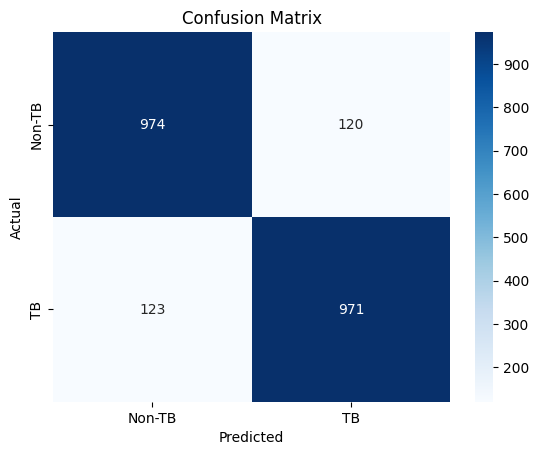

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Non-TB", "TB"], yticklabels=["Non-TB", "TB"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()
